In [2]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

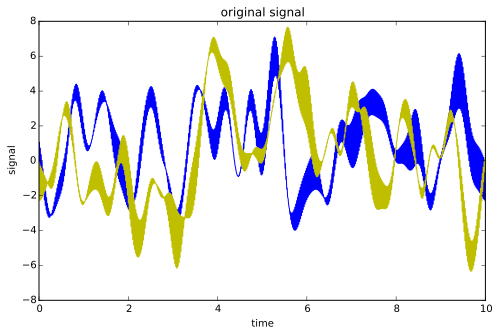

In [157]:
# generate two random signals
fs = 100.0  #  time step:1/fs
t = np.arange(0,10,1/fs)[np.newaxis].transpose()
num_points = t.size

# matrix variate normal property 
M = np.matrix(np.zeros((2,t.size)))

U = np.matrix([[8, 6], [6, 6]])
k1 = gpy.kern.RBF(1, variance=1, lengthscale=0.1)
V = k1.K(t)  
x = np.random.multivariate_normal(np.zeros(t.size*2), np.kron(V,U)+np.identity(2*t.size)*1E-8, 1).reshape(2,t.size)

# plot signal
plt.plot(t.flatten(), x[0,], 'b')
plt.plot(t.flatten(), x[1,], 'y')
plt.xlabel('time');plt.ylabel('signal');plt.title('original signal')



In [136]:
# covariance of original signals
sigma0 = np.cov(x)
sigma0

array([[ 9.54617031,  4.16246095],
       [ 4.16246095,  9.27457418]])

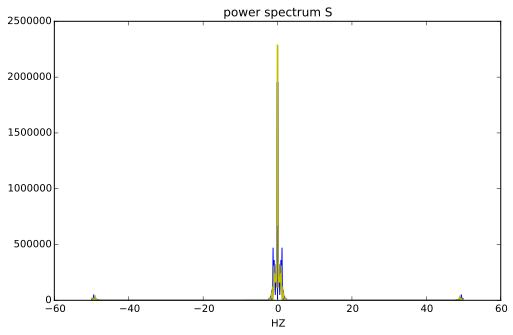

In [139]:
# fourier transform of signal
x1 = x[0,]
x2 = x[1,]
xF1 = np.fft.fft(x1)
xF2 = np.fft.fft(x2)

# power spectrum S
# or S = np.conjugate(xF) * xF
S1 = abs(xF1)**2
S2 = abs(xF2)**2
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)

# plot power spectrum 
plt.plot(freqs[idx], S1[idx])  
plt.title("power spectrum S")
plt.xlabel('HZ')

plt.plot(freqs[idx], S2[idx],'y') 
plt.title("power spectrum S")
plt.xlabel('HZ')

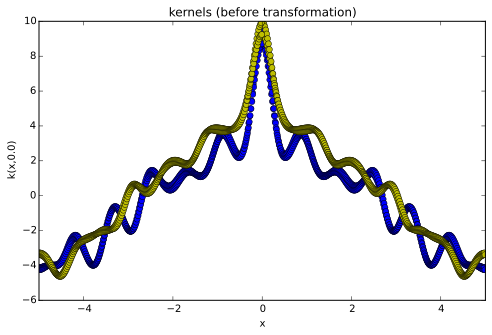

In [141]:
# autocorrelation 
# Bochner's theorem (spectral density to autocorrelaion ： ifft) 
R1 = ifft(S1)
R2 = ifft(S2)

# autocovariance matrix (C) using autocorrelation. As mean is zero, C(i,j) = R(asb(i-j))
C1 = np.matrix([[R1[abs(i-j)] for i in range(R1.size)] for j in range(R1.size)])/t.size
C2 = np.matrix([[R2[abs(i-j)] for i in range(R2.size)] for j in range(R2.size)])/t.size
 
# plot inferred kernels before transformation 
# inferred kernels are generated using inferred covariance matrix 
# inferred kernels are not exact the same as ground truth because of randomness of generating data at the first place. 
plt.plot(t[idx]-5, np.array(C1[0,]).flatten(), 'bo')
_ = plt.plot(t[idx]-5, np.array(C2[0,]).flatten(), 'yo')

plt.xlim((-5,5))
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (before transformation)')



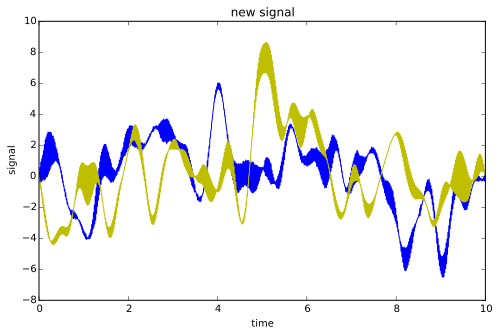

In [143]:
# one ramdom draw from GP using inferred autocovariance matrix (C) 
mu = np.zeros((R1.size)) 
z1 = np.random.multivariate_normal(mu,C1,1)
z2 = np.random.multivariate_normal(mu,C2,1)

z = np.vstack([z1,z2])
plt.plot(t.flatten(), z[0,], 'b')
plt.plot(t.flatten(), z[1,], 'y')
plt.xlabel('time');plt.ylabel('signal');plt.title('new signal')

In [144]:
# covariance
sigma1 = np.cov(z)
sigma1.real

array([[ 5.25272486,  0.65610601],
       [ 0.65610601,  6.44107336]])

In [151]:
# draw 10000 times from signal 1 and signal 2
# covariance is maximum liklihood estimator (average） 

zz1 = np.random.multivariate_normal(mu,C1,10000)
zz2 = np.random.multivariate_normal(mu,C2,10000)

sigma_sum = 0
for i in xrange(1, 10000):
    zz = np.vstack([zz1[i,],zz2[i,]])
    sigma_sum = sigma_sum + np.cov(zz)

sigma1 = sigma_sum/10000 

# we expect off-diagonal value of sigmal1 to be close to zero (confirmed)
sigma1.real

array([[  9.52032358e+00,  -4.51316337e-03],
       [ -4.51316337e-03,   9.25056185e+00]])

In [152]:
# from sigma1 to sigma0 
# Cholesky factorization 
# goal: to infer L such that sigma0 = L* sigma1* L.H
# sigma1 = L1*I*L1.H 
# I = inverse(L1) *sigma1* inverse(L1.H)
# sigma0 = L0*I*L0.H 
# sigma0 = L0*inverse(L1) *sigma1* inverse(L1.H)*L0.H
#        = [L0*inverse(L1)] *sigma1* [L0*inverse(L1)].H
# Thus, L = L0*inverse(L1)

L1 = np.linalg.cholesky(sigma1)
L0 = np.linalg.cholesky(sigma0)
L = np.dot(L0, inv(L1)) 

# verify sigma0 = L* sigma1* L.H
print np.dot(np.dot(L, sigma1),L.T.conj()).real
print sigma0.real

[[ 9.54617031  4.16246095]
 [ 4.16246095  9.27457418]]
[[ 9.54617031  4.16246095]
 [ 4.16246095  9.27457418]]


In [153]:
## transform signal draw 

z_transformed = np.dot(L,z)

# covariance
sigma2 = np.cov(z_transformed)

# may have variations from we expect (sigma0), as only single draw
print sigma2.real

[[ 5.26698548  2.88880607]
 [ 2.88880607  6.71239336]]


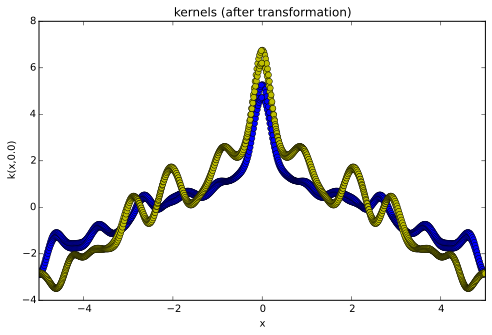

In [154]:
# power spectrum (a combination of s1 and s2)
zF1 = np.fft.fft(z_transformed[0,])
zF2 = np.fft.fft(z_transformed[1,])
zS1 = abs(zF1)**2
zS2 = abs(zF2)**2 

zR1 = ifft(zS1)
zR2 = ifft(zS2)

# autocovariance matrix (C) using autocorrelation. As mean is zero, C(i,j) = R(asb(i-j))
zC1 = np.matrix([[zR1[abs(i-j)] for i in range(zR1.size)] for j in range(zR1.size)])/t.size
zC2 = np.matrix([[zR2[abs(i-j)] for i in range(zR2.size)] for j in range(zR2.size)])/t.size

#plot kernels after transfomation
plt.plot(t[idx]-5, np.array(zC1[0,]).flatten(), 'bo')
_ = plt.plot(t[idx]-5, np.array(zC2[0,]).flatten(), 'yo')
plt.xlim((-5,5))
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (after transformation)')

In [155]:
# transform 10000 draws and take average (approximately expected value)
sigma_sum = 0
for i in xrange(1, 10000):
    zz = np.vstack([zz1[i,],zz2[i,]])
    zz_transformed = np.dot(L,zz)
    sigma_sum = sigma_sum + np.cov( zz_transformed)

sigma2 = sigma_sum/10000 

# expect sigma2 can recover sigma0 (confirmed)
print sigma2.real
print sigma0.real

[[ 9.54617031  4.16246095]
 [ 4.16246095  9.27457418]]
[[ 9.54617031  4.16246095]
 [ 4.16246095  9.27457418]]
